# Trajectory inference analysis: PAGA

Partly following tutorial https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

### Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

import scipy
import numpy as np
import matplotlib.pyplot as plt


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(5, 5), facecolor='white', color_map = 'viridis_r')  

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.1.0
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
google              NA
h5py                3.8.0
hypergeom_ufunc     NA
igraph              0.10.3
invgauss_ufunc      NA
ipykernel           6.20.2
ipython_genutils    0.2.0
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
jupyter_server      2.1.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
markupsafe          2.1.2
matplotlib          3.6.3
mpl

## Loading data

In order to speed up the computations during the exercises, we will be using a subset of a bone marrow dataset (originally containing about 100K cells). The bone marrow is the source of adult immune cells, and contains virtually all differentiation stages of cell from the immune system which later circulate in the blood to all other organs.

![](Hematopoiesis.png)

All the data has been preprocessed with Seurat. The file `trajectory_scanpy_filtered.h5ad` was converted from the Seurat object using the `SeuratDisk` package. For more information on how it was done, have a look at the script: `convert_to_h5ad.R` in the github repo.


In [3]:
infile = './../data/bone_marrow/trajectory_scanpy_filtered.h5ad'
adata = sc.read_h5ad(infile)

In [4]:
# check what is in the object
adata

AnnData object with n_obs × n_vars = 5828 × 3585
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batches', 'dataset', 'nCount', 'nUMI', 'pMito', 'pRibo', 'pHb', 'pChY', 'pChX', 'pnonXY', 'pPCG', 'pNCG', 'pMito_UMIs', 'pRibo_UMIs', 'pHb_UMIs', 'pChY_UMIs', 'pChX_UMIs', 'pnonXY_UMIs', 'pPCG_UMIs', 'pNCG_UMIs', 'SEL_nCount', 'SEL_nUMI', 'SEL_pMito', 'SEL_pRibo', 'SEL_pHb', 'SEL_pChY', 'SEL_pChX', 'SEL_pnonXY', 'SEL_pPCG', 'SEL_pNCG', 'SEL_pMito_UMIs', 'SEL_pRibo_UMIs', 'SEL_pHb_UMIs', 'SEL_pChY_UMIs', 'SEL_pChX_UMIs', 'SEL_pnonXY_UMIs', 'SEL_pPCG_UMIs', 'SEL_pNCG_UMIs', 'S.Score', 'G2M.Score', 'Phase', 'metadata_clusters', 'clusters', 'outlier', 'subgroups', 'clusters_use'
    var: 'features'
    obsm: 'X_harmony', 'X_harmony_Phase', 'X_pca', 'X_umap', 'X_umap3d'
    varm: 'PCs'

Check that the variable names are correct.

In [5]:
adata.var

features
0610040J01Rik  0610040J01Rik
1190007I07Rik  1190007I07Rik
1500009L16Rik  1500009L16Rik
1700012B09Rik  1700012B09Rik
1700020L24Rik  1700020L24Rik
...                      ...
Sqor                    Sqor
Sting1                Sting1
Tent5a                Tent5a
Tlcd4                  Tlcd4
Znrd2                  Znrd2

[3585 rows x 1 columns]

In [6]:
# check what you have in the X matrix, should be lognormalized counts.
print(adata.X[:10,:10])

  (0, 4)	0.11622072805743532
  (0, 8)	0.4800893970571722
  (1, 8)	0.2478910541698065
  (1, 9)	0.17188973970230348
  (2, 1)	0.09413397843954842
  (2, 7)	0.18016412971724202
  (3, 1)	0.08438841021254412
  (3, 4)	0.08438841021254412
  (3, 7)	0.08438841021254412
  (3, 8)	0.3648216463668793
  (4, 1)	0.14198147850903975
  (4, 8)	0.14198147850903975
  (5, 1)	0.17953169693896723
  (5, 8)	0.17953169693896723
  (5, 9)	0.17953169693896723
  (6, 4)	0.2319546390006887
  (6, 8)	0.42010741700351195
  (7, 1)	0.1775659421407816
  (7, 8)	0.39593115482156394
  (7, 9)	0.09271901219711086
  (8, 1)	0.12089079757716388
  (8, 8)	0.22873058755480363
  (9, 1)	0.08915380247493314
  (9, 4)	0.08915380247493314
  (9, 8)	0.38270398718590104


## Explore the data

There is a umap and clusters provided with the object, first plot some information from the previous analysis onto the umap.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


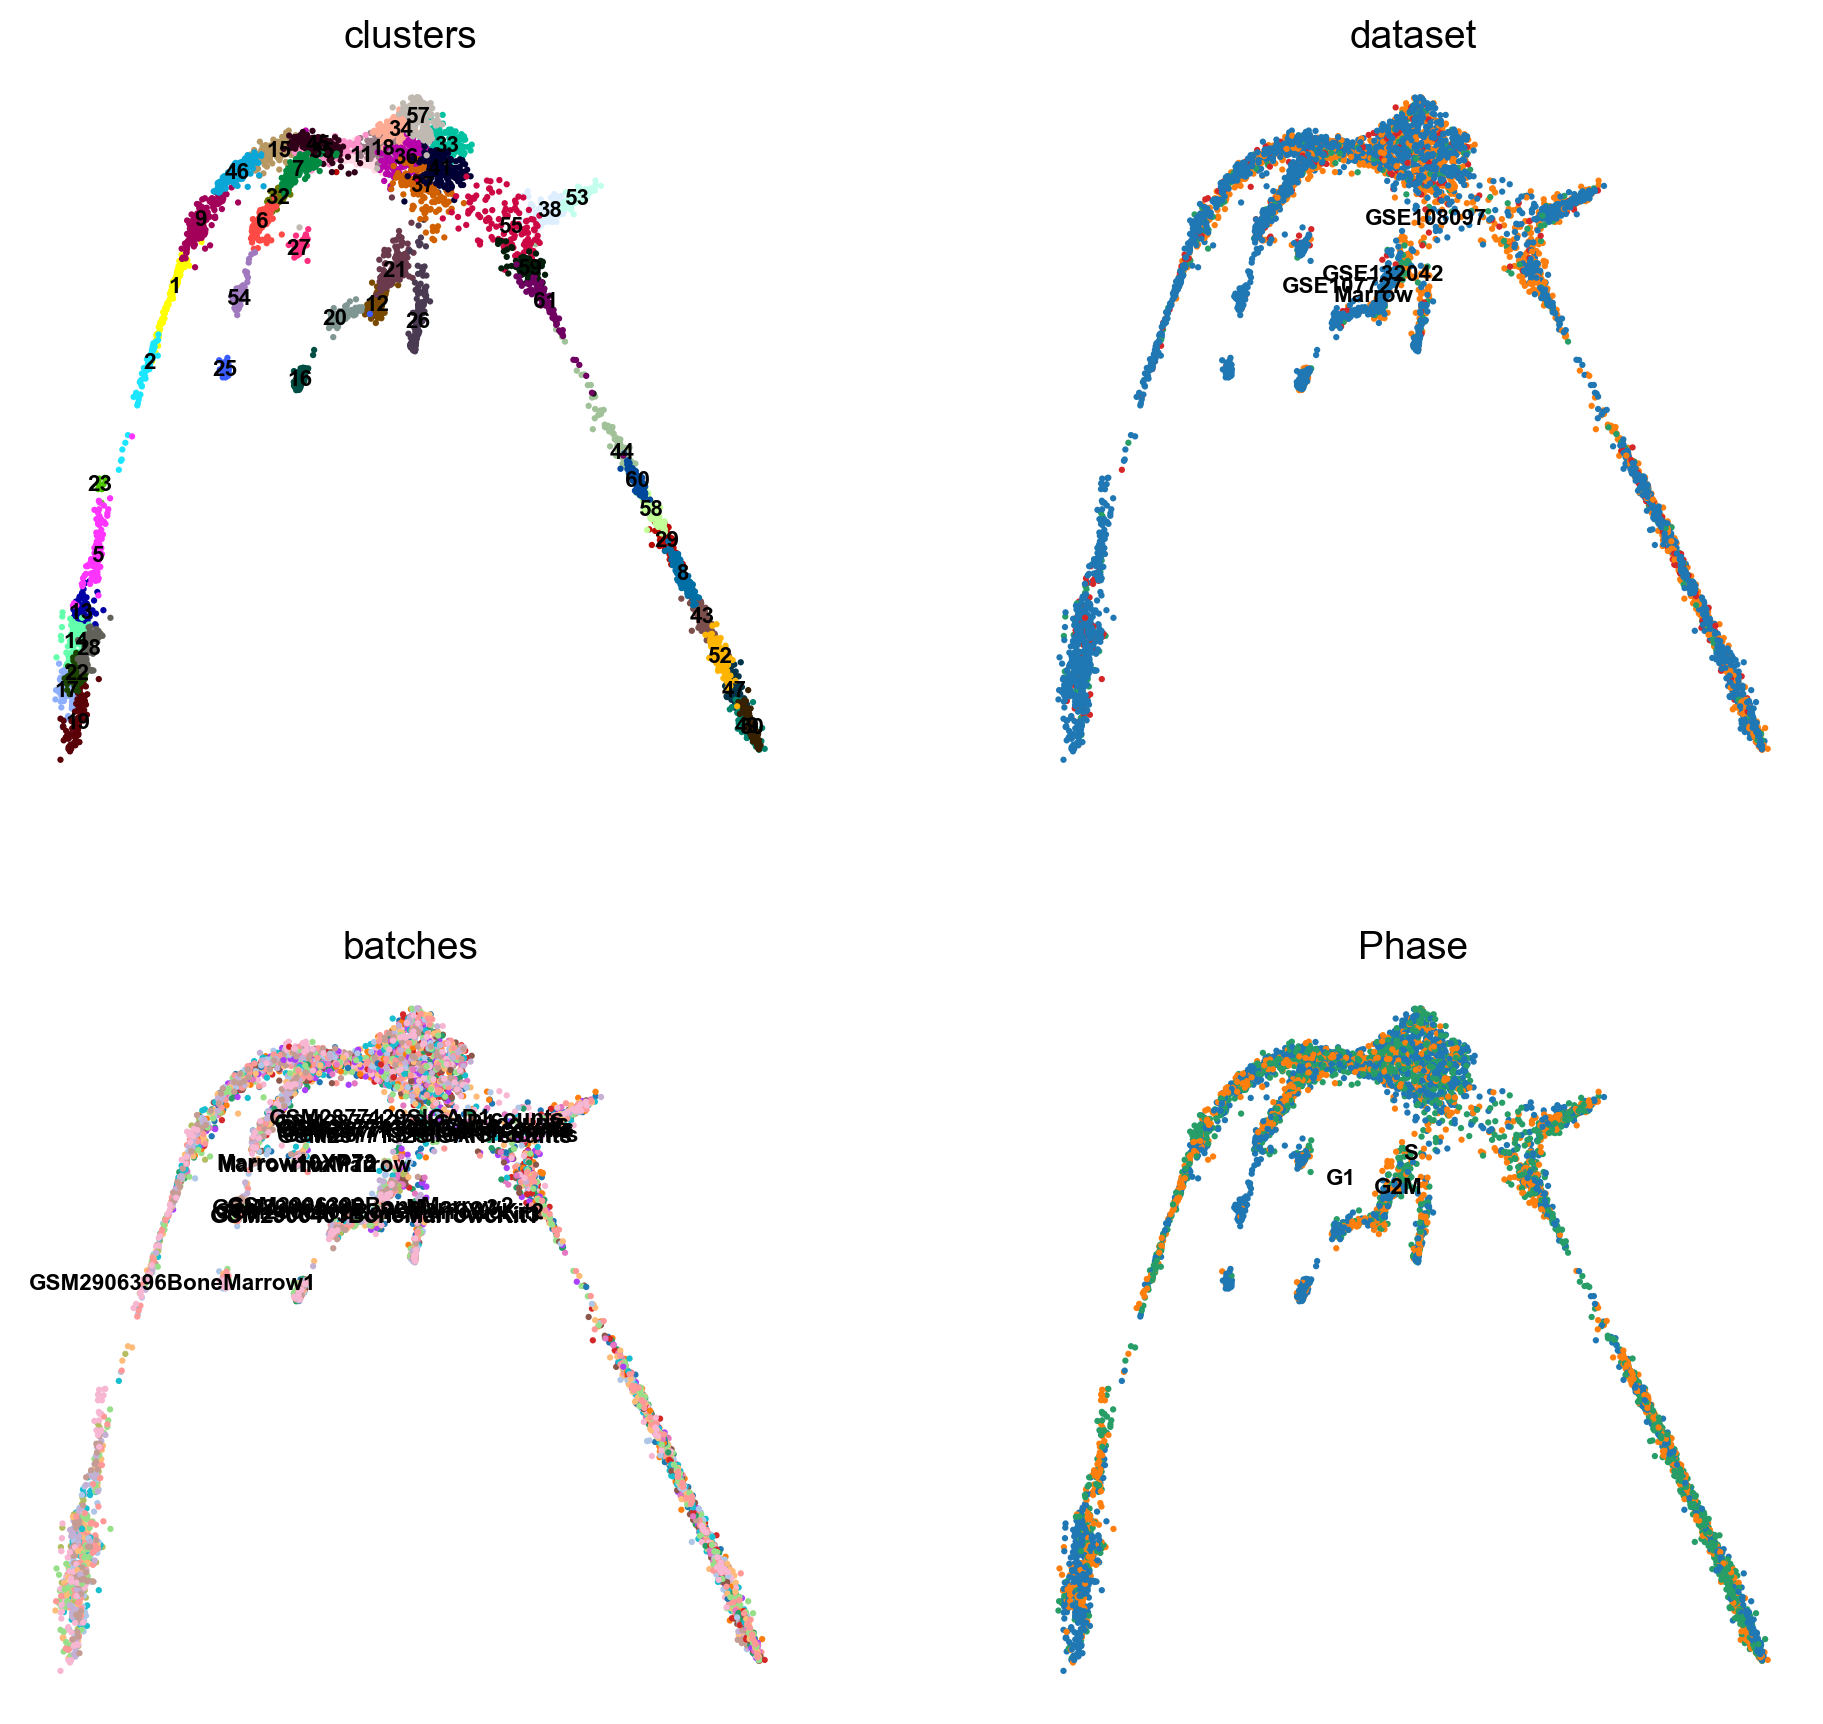

In [7]:
sc.pl.umap(adata, color = ['clusters','dataset','batches','Phase'],legend_loc = 'on data', legend_fontsize = 'xx-small', ncols = 2)

It is crucial that you performing analysis of a dataset understands what is going on, what are the clusters you see in your data and most importantly How are the clusters related to each other?. Well, let’s explore the data a bit. With the help of this table, write down which cluster numbers in your dataset express these key markers.

| Marker  | Cell Type               |
|---------|-------------------------|
| Cd34    | HSC progenitor          |
| Ms4a1   | B cell lineage          |
| Cd3e    | T cell lineage          |
| Ltf     | Granulocyte lineage     |
| Cst3    | Monocyte lineage        |
| Mcpt8   | Mast Cell lineage       |
| Alas2   | RBC lineage             |
| Siglech | Dendritic cell lineage  |
| C1qc    | Macrophage cell lineage |
| Pf4     | Megakaryocyte cell lineage |

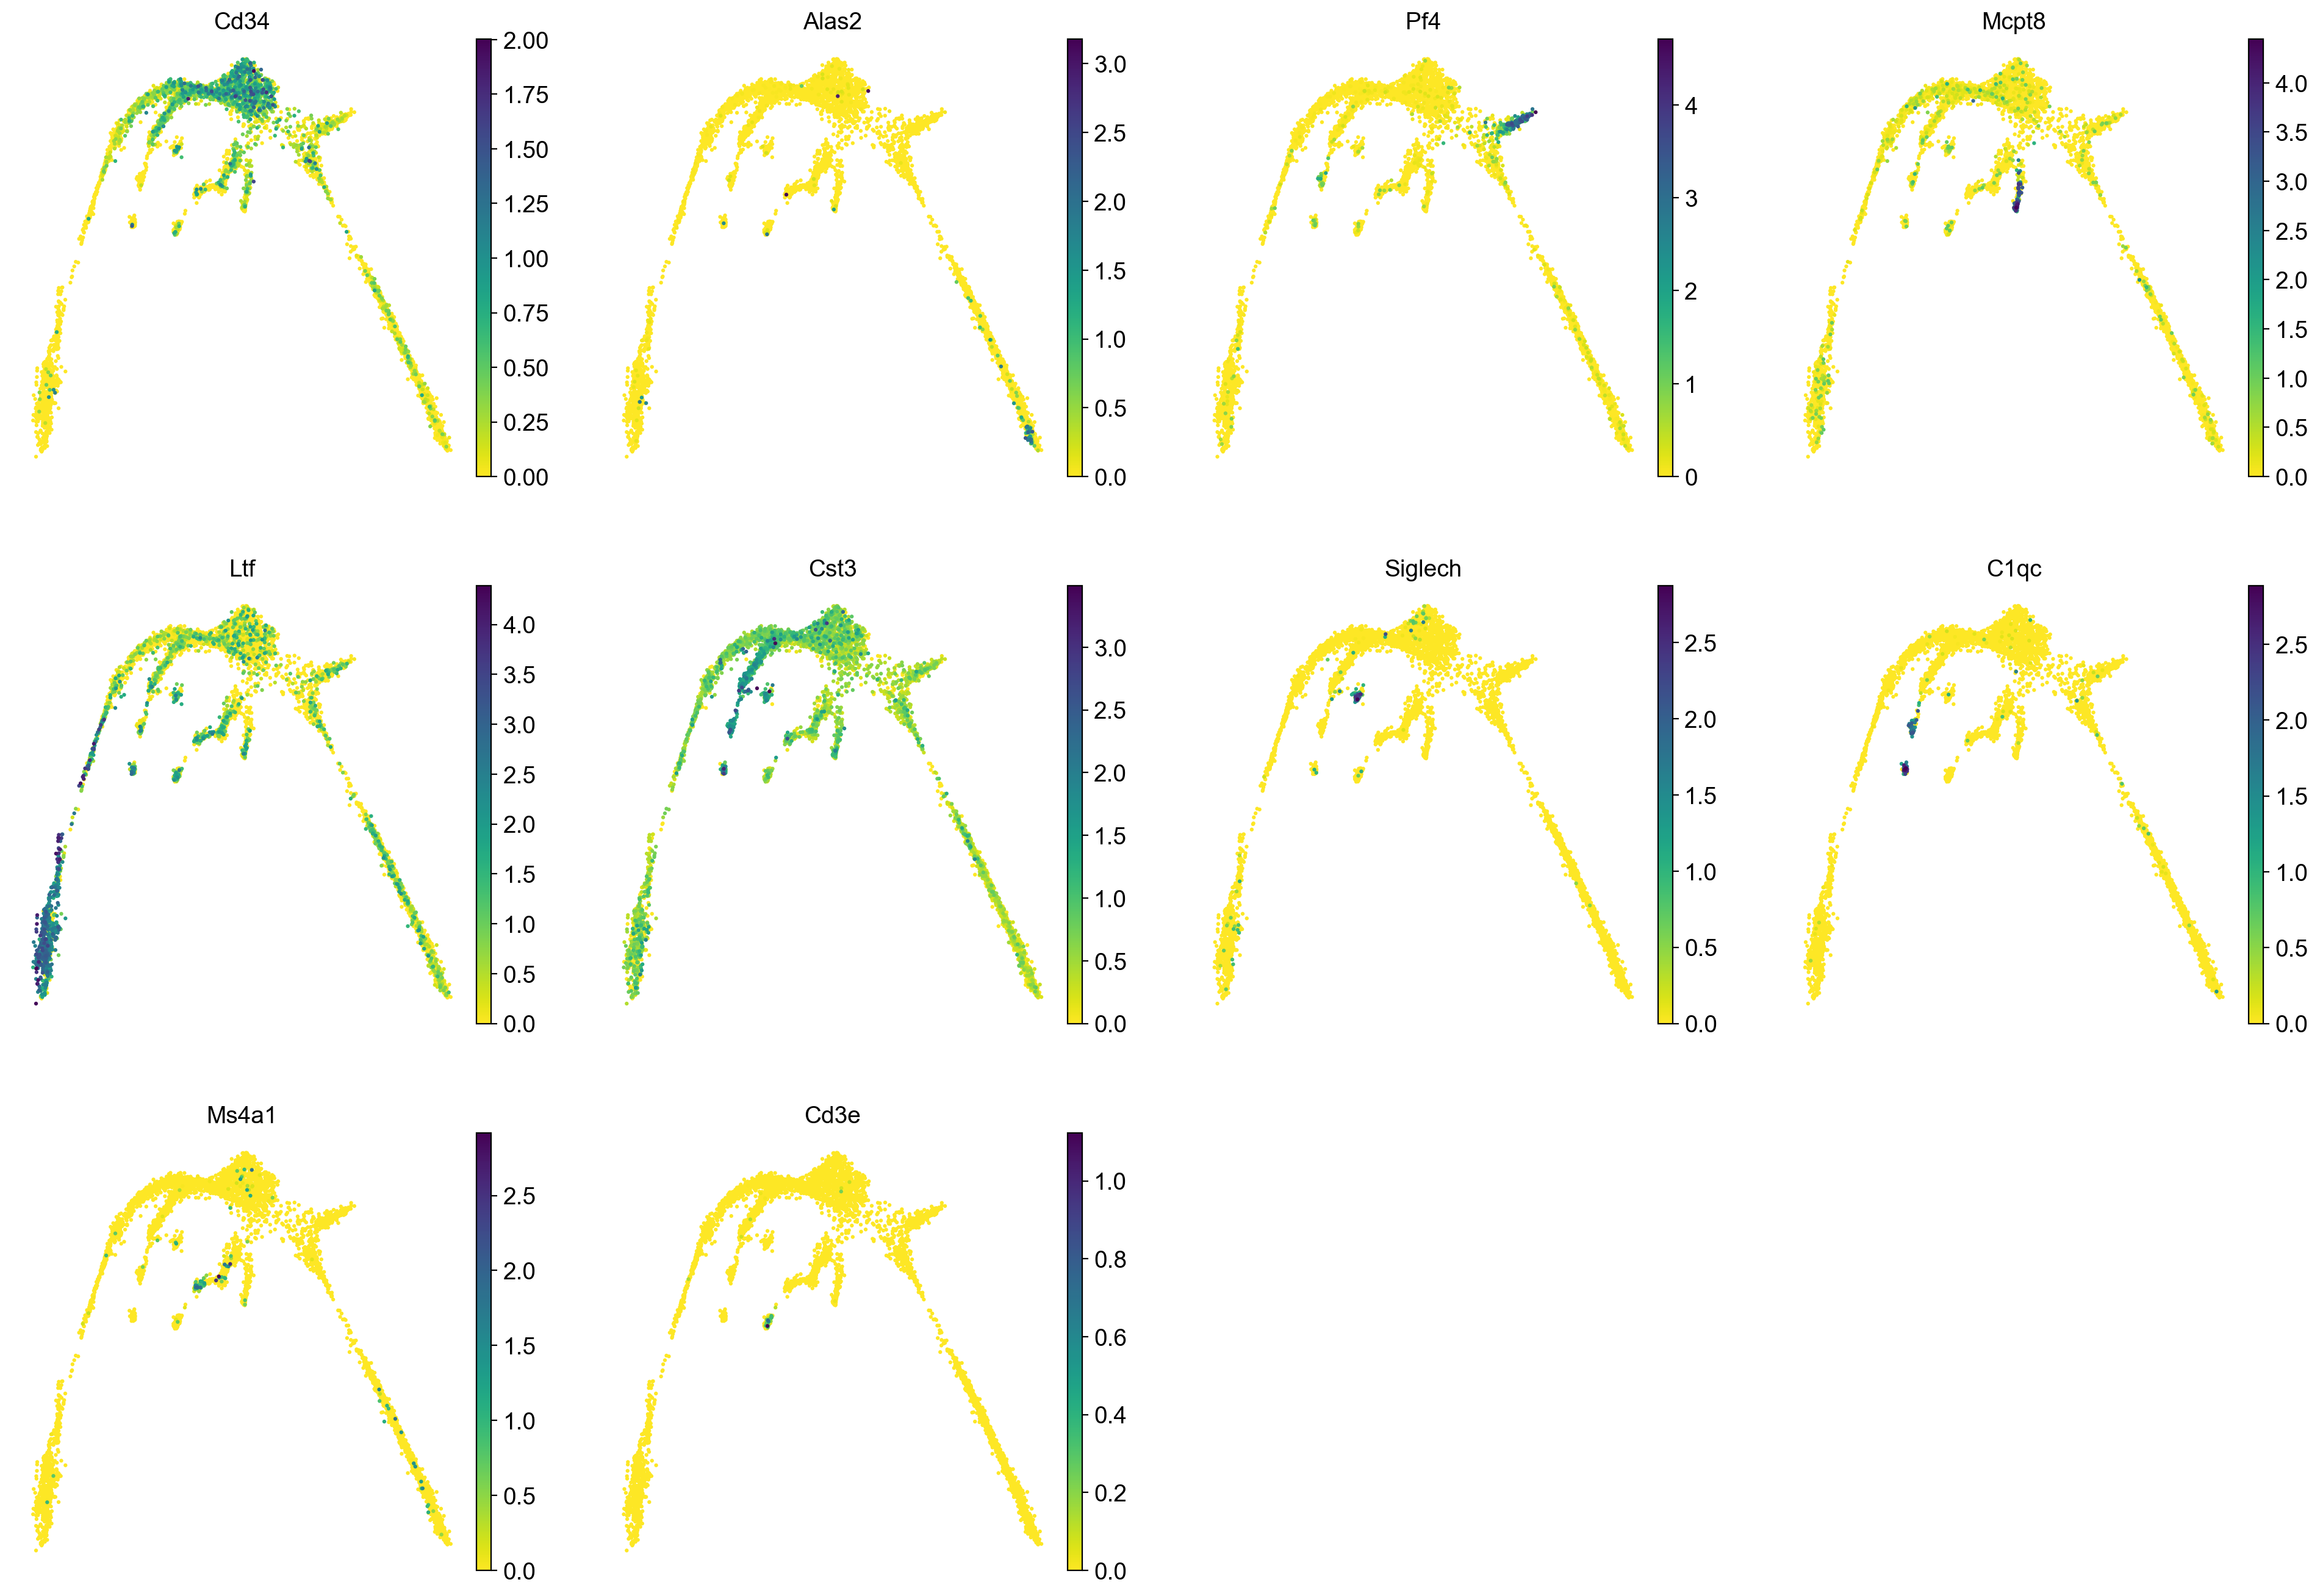

In [8]:
markers = ["Cd34","Alas2","Pf4","Mcpt8","Ltf","Cst3", "Siglech", "C1qc", "Ms4a1", "Cd3e", ]

sc.pl.umap(adata, color = markers, use_raw = False, ncols = 4)

## Rerun analysis in Scanpy

Redo clustering and umap using the basic Scanpy pipeline. Use the provided "X_harmony_Phase" dimensionality reduction as the staring point. 

In [9]:
# first, store the old umap with a new name so it is not overwritten
adata.obsm['X_umap_old'] = adata.obsm['X_umap']

In [10]:
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20, use_rep="X_harmony_Phase")
sc.tl.umap(adata, min_dist=0.4, spread=3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


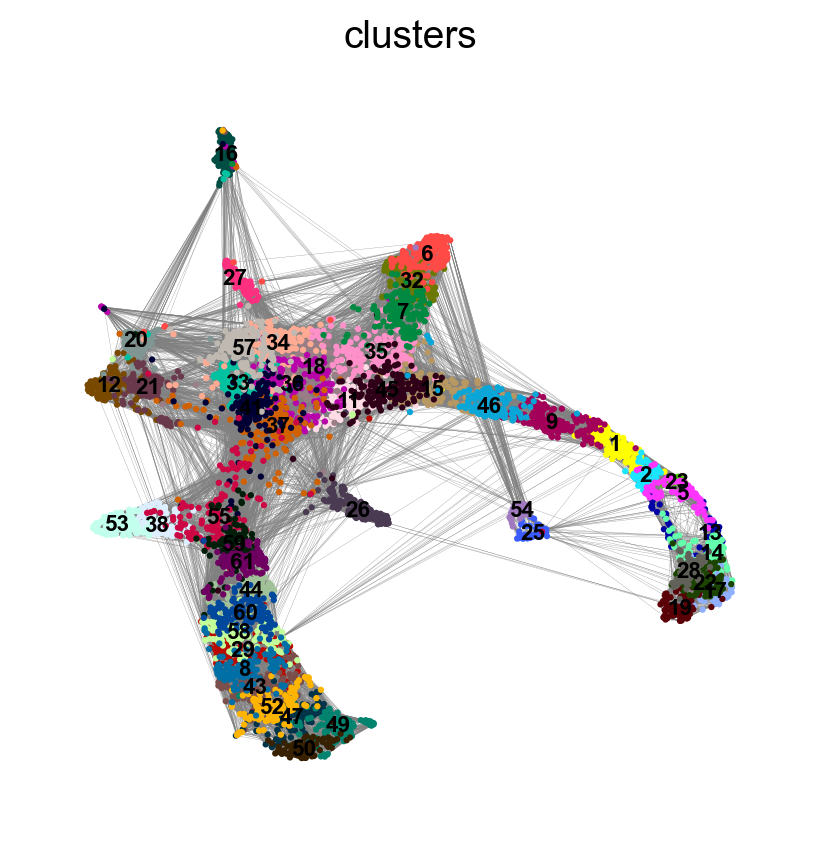

In [11]:
#sc.tl.umap(adata, min_dist=0.6, spread=1.5)
sc.pl.umap(adata, color = ['clusters'],legend_loc = 'on data', legend_fontsize = 'xx-small', edges = True)

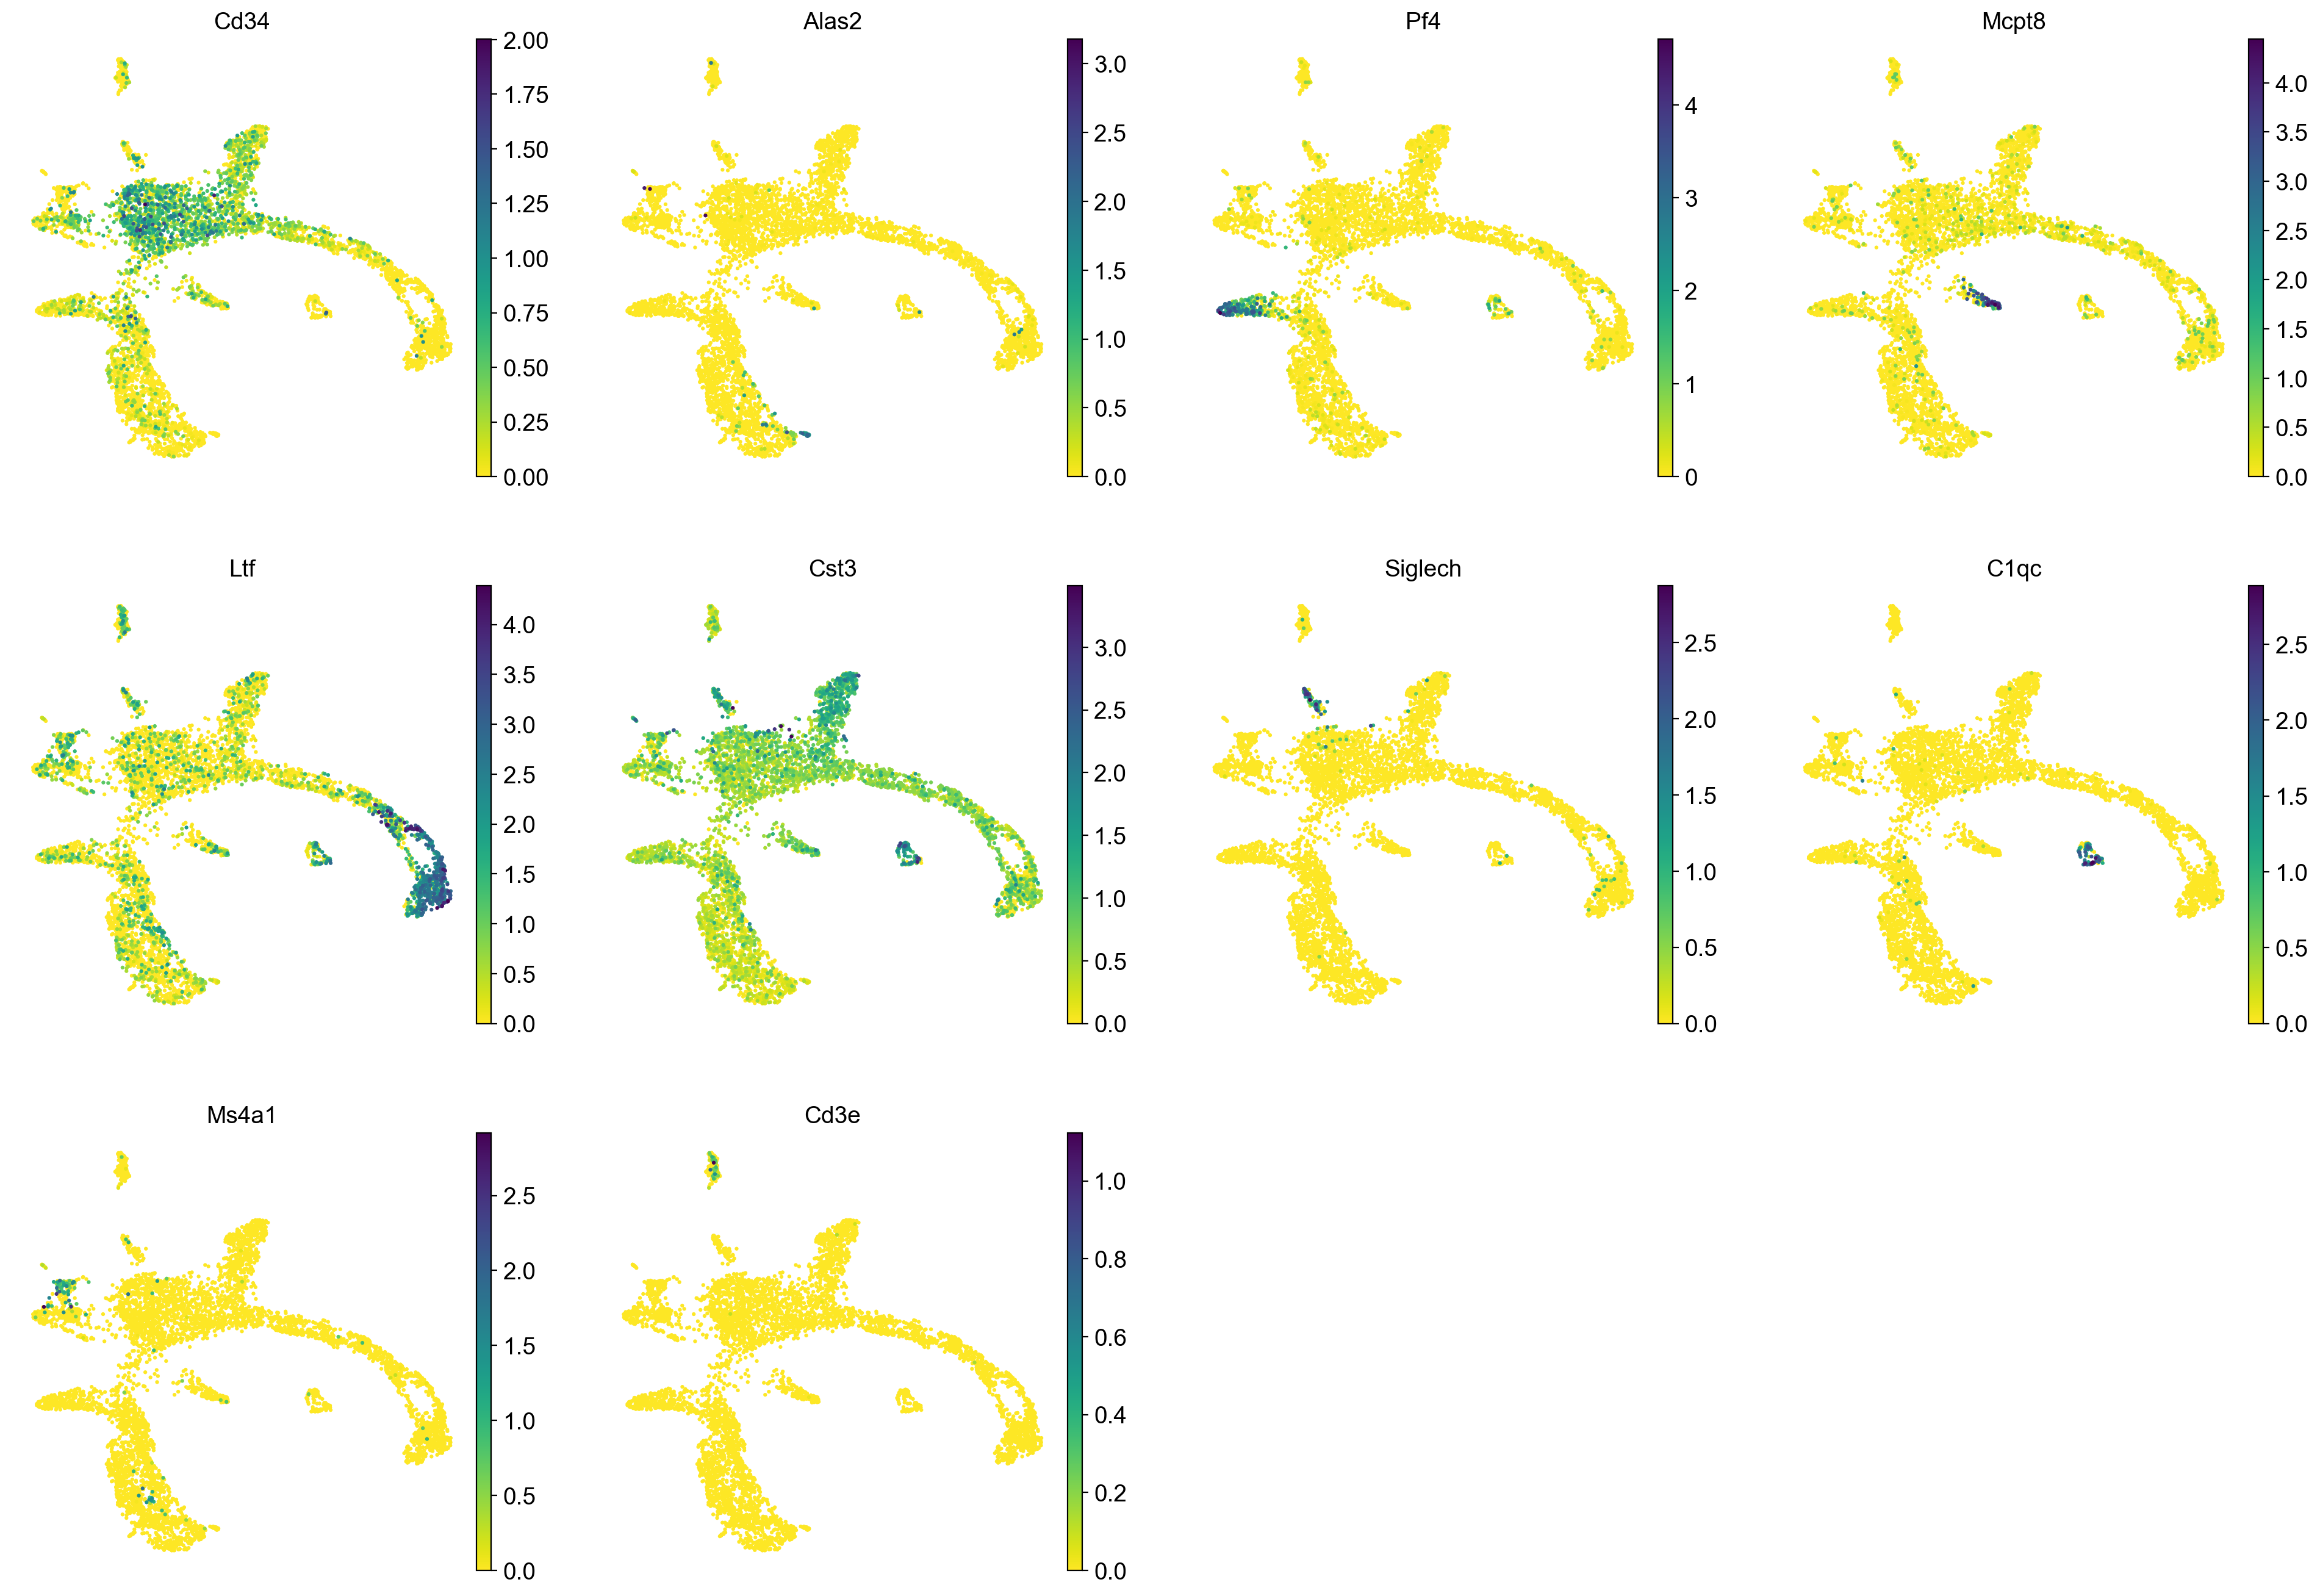

In [12]:
sc.pl.umap(adata, color = markers, use_raw = False, ncols = 4)


running Leiden clustering
    finished: found 16 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_1.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


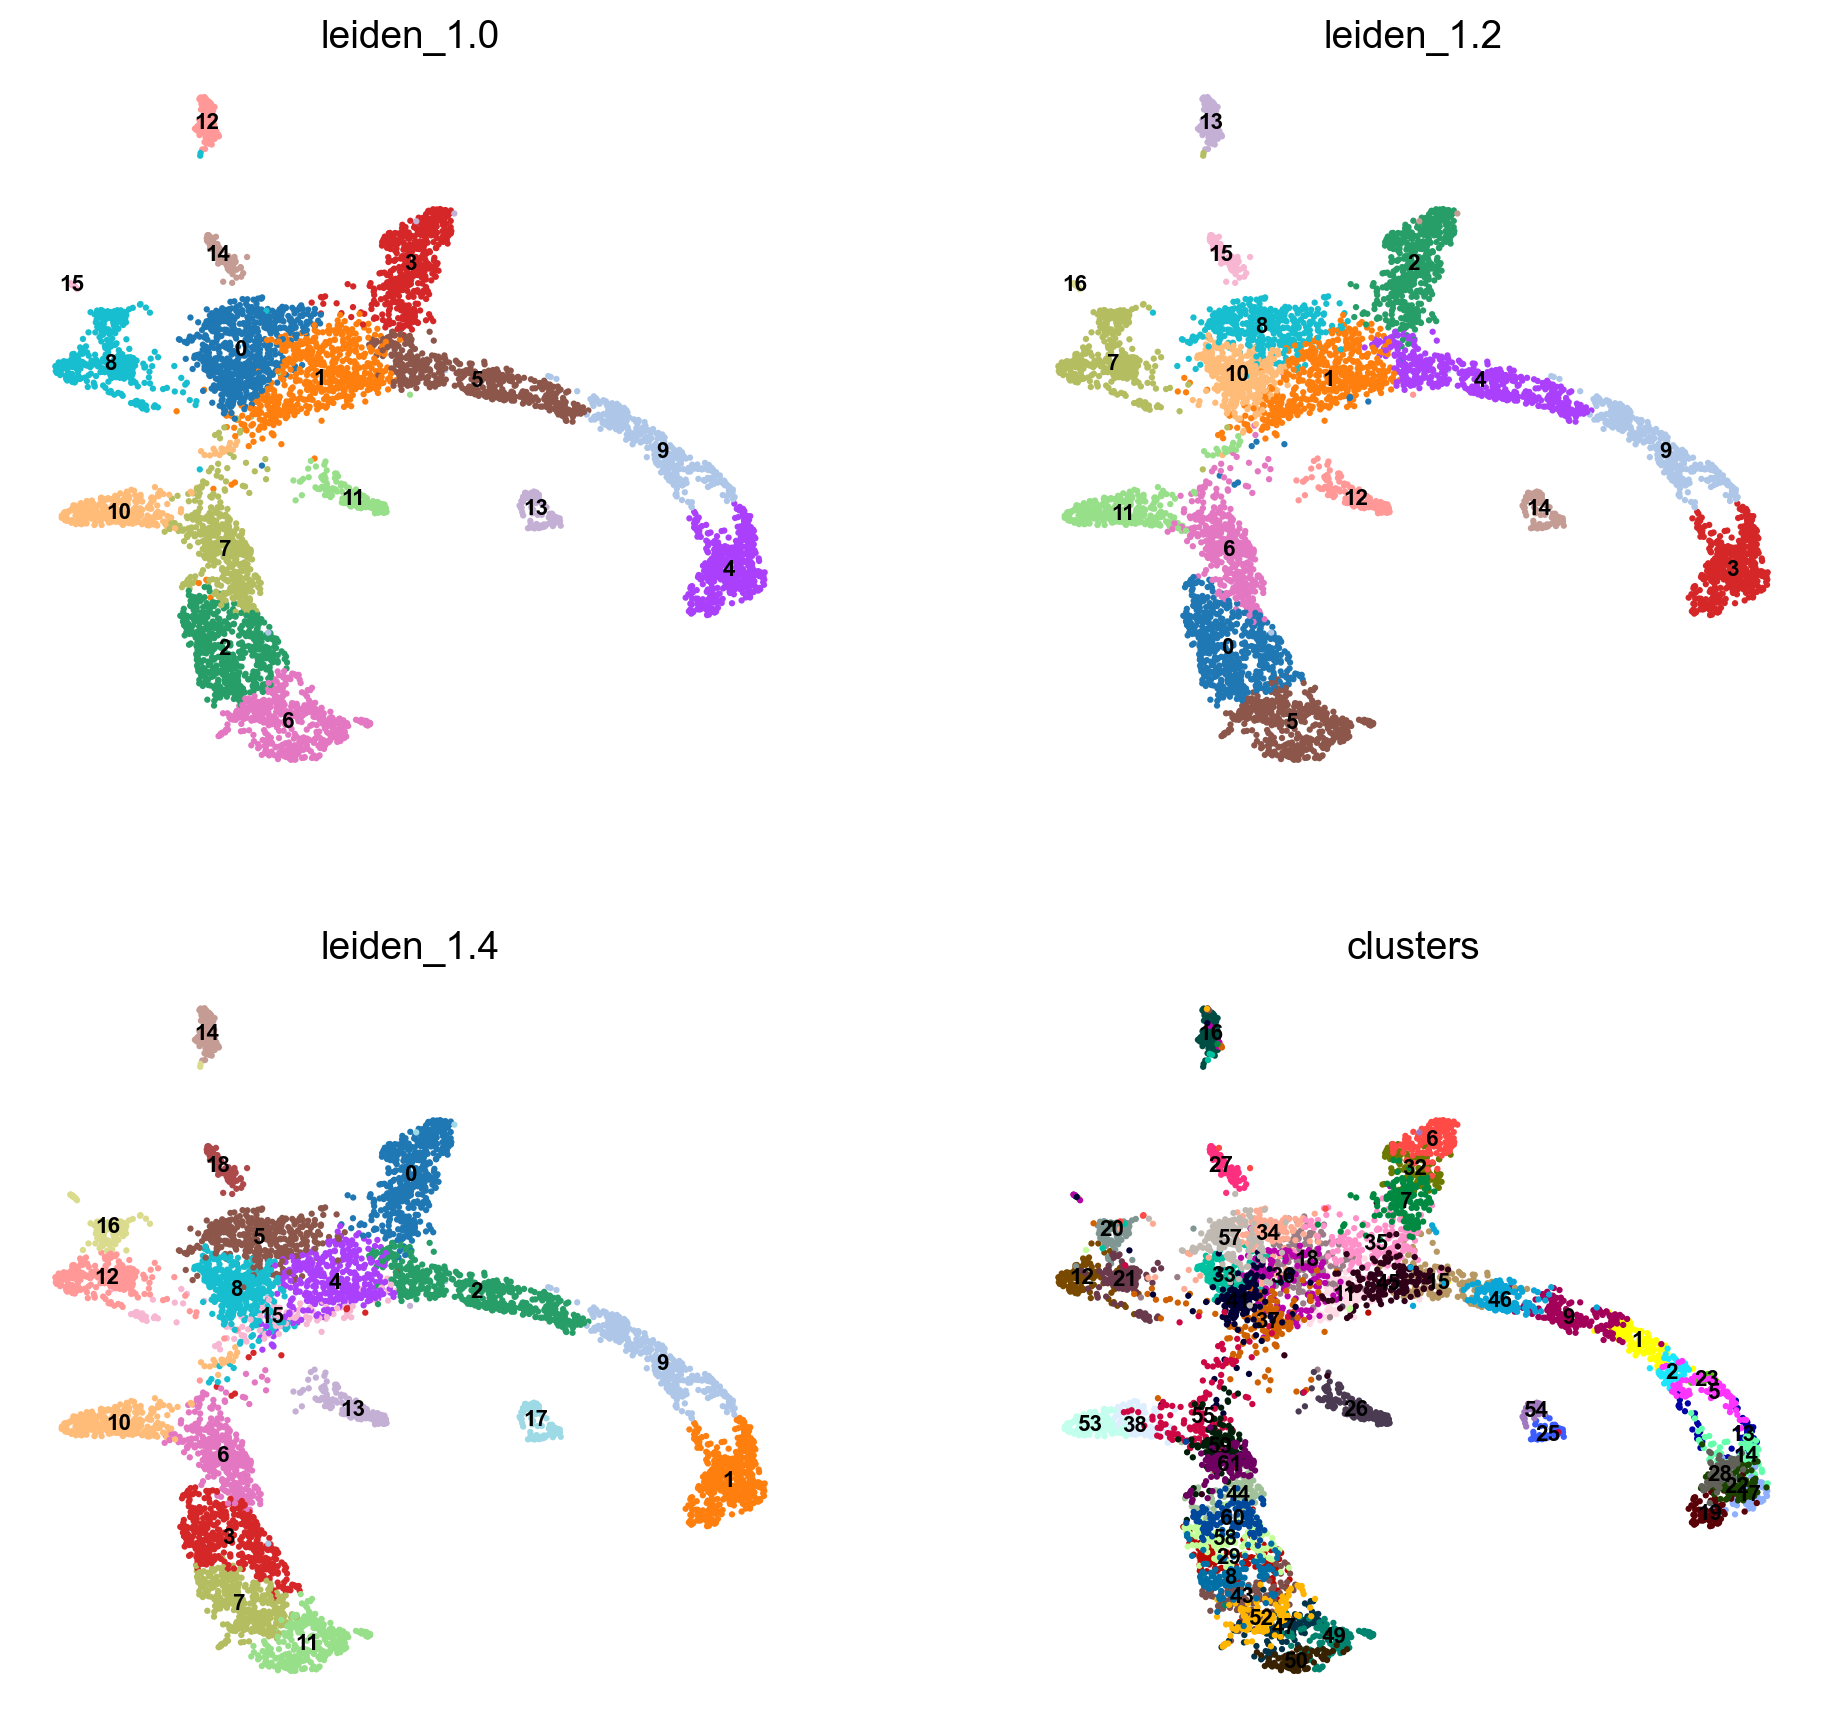

In [13]:
# Redo clustering as well

sc.tl.leiden(adata, key_added = "leiden_1.0", resolution = 1.0) # default resolution in 1.0
sc.tl.leiden(adata, key_added = "leiden_1.2", resolution = 1.2) # default resolution in 1.0
sc.tl.leiden(adata, key_added = "leiden_1.4", resolution = 1.4) # default resolution in 1.0

#sc.tl.louvain(adata, key_added = "leiden_1.0") # default resolution in 1.0

sc.pl.umap(adata, color = ['leiden_1.0', 'leiden_1.2', 'leiden_1.4','clusters'],legend_loc = 'on data', legend_fontsize = 'xx-small', ncols =2)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


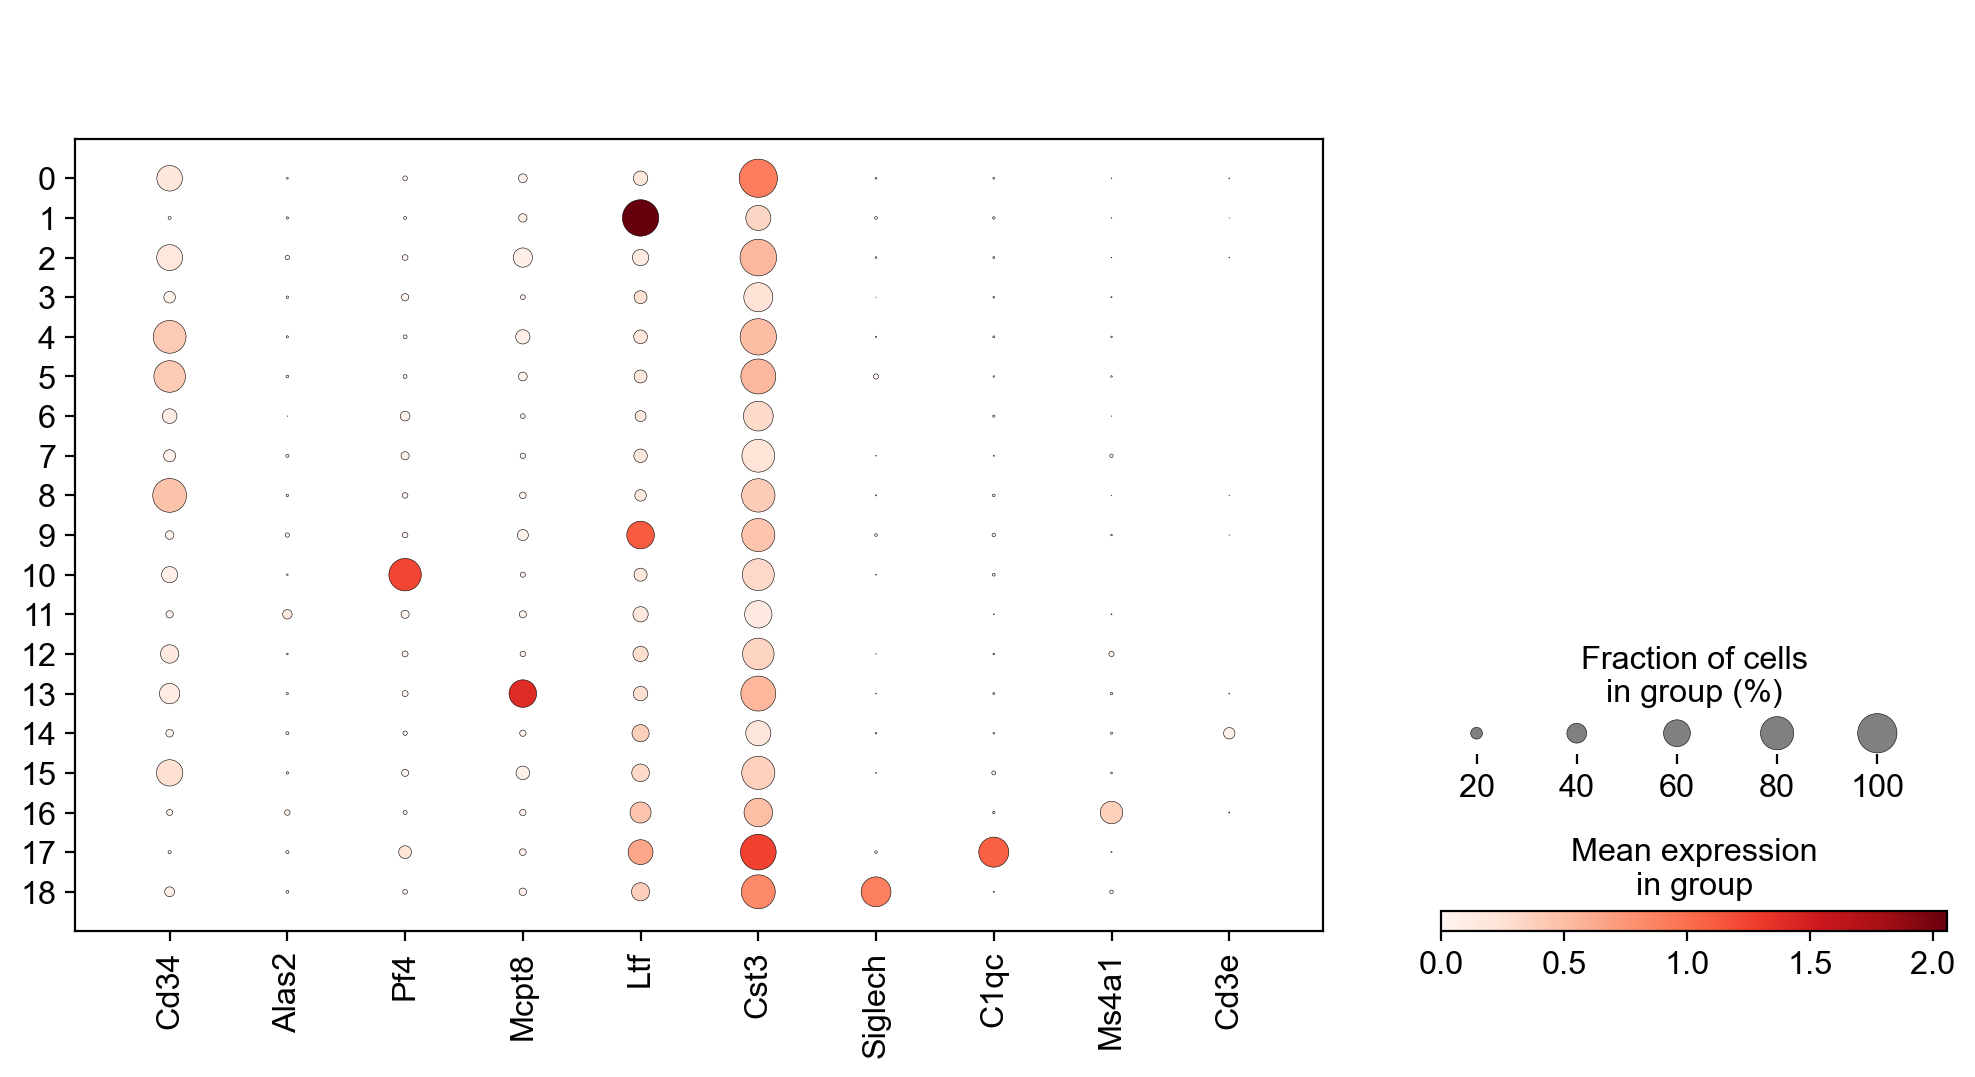

In [14]:
_, ax = plt.subplots(figsize=(12, 6)) 
sc.pl.dotplot(adata, var_names=markers,  groupby="leiden_1.4", use_raw = False, ax = ax)

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


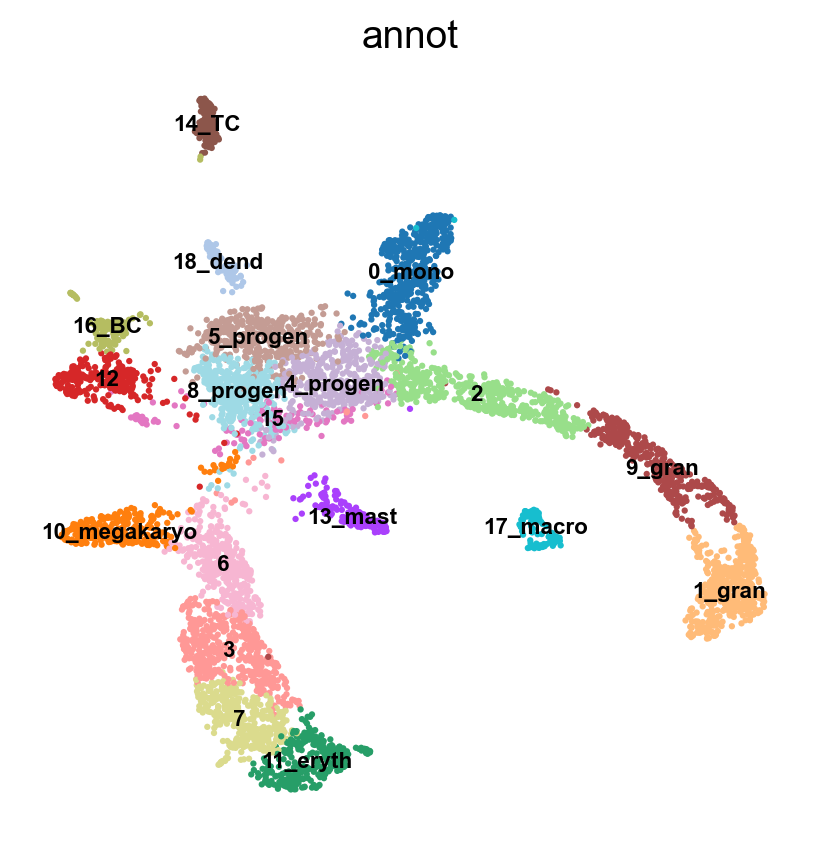

leiden_1.4  
0_mono          509
1_gran          487
2               479
3               463
4_progen        387
5_progen        384
7               368
6               368
8_progen        367
9_gran          366
10_megakaryo    301
11_eryth        294
12              276
13_mast         159
14_TC           151
15              128
16_BC           124
17_macro        116
18_dend         101
dtype: int64

In [15]:
#Rename clusters with really clear markers, the rest are left unlabelled.

annot = pd.DataFrame(adata.obs['leiden_1.4'].astype('string'))
annot[annot['leiden_1.4'] == '10'] = '10_megakaryo' #Pf4
annot[annot['leiden_1.4'] == '17'] = '17_macro'  #C1qc
annot[annot['leiden_1.4'] == '11'] = '11_eryth' #Alas2
annot[annot['leiden_1.4'] == '18'] = '18_dend' #Siglech
annot[annot['leiden_1.4'] == '13'] = '13_mast' #Mcpt8
annot[annot['leiden_1.4'] == '0'] = '0_mono' #Cts3
annot[annot['leiden_1.4'] == '1'] = '1_gran' #Ltf
annot[annot['leiden_1.4'] == '9'] = '9_gran'
annot[annot['leiden_1.4'] == '14'] = '14_TC' #Cd3e
annot[annot['leiden_1.4'] == '16'] = '16_BC' #Ms4a1
annot[annot['leiden_1.4'] == '8'] = '8_progen'  # Cd34
annot[annot['leiden_1.4'] == '4'] = '4_progen' 
annot[annot['leiden_1.4'] == '5'] = '5_progen'

adata.obs['annot']=annot['leiden_1.4'].astype('category')

sc.pl.umap(adata, color = 'annot',legend_loc = 'on data', legend_fontsize = 'xx-small', ncols =2)

annot.value_counts()
#type(annot)


# astype('category')

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


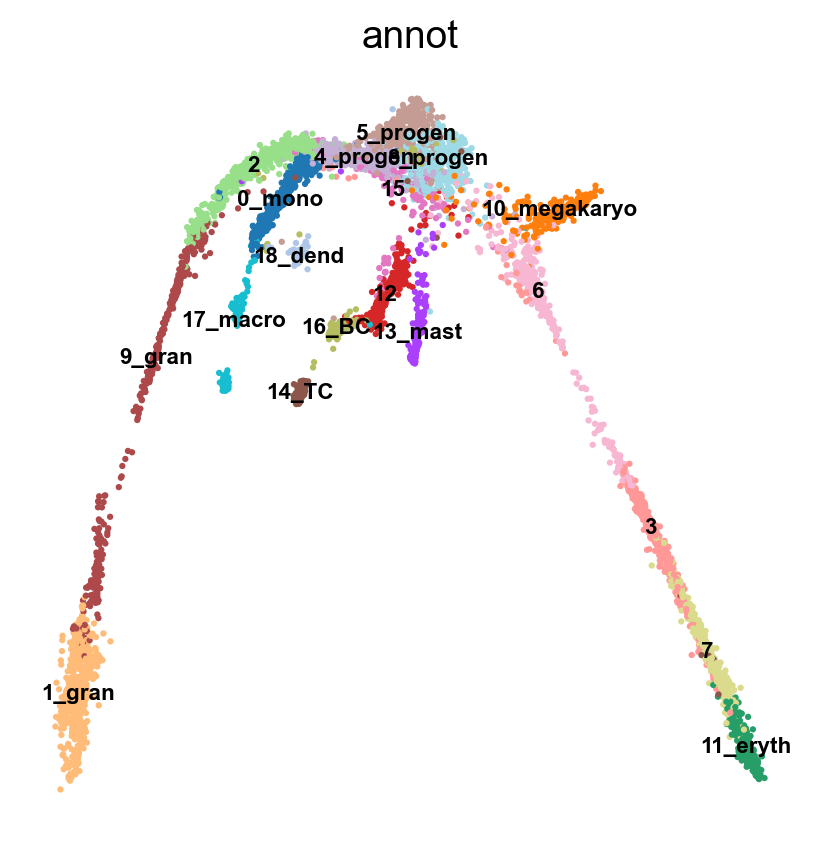

In [16]:
# plot onto the Seurat embedding:
sc.pl.embedding(adata, basis='X_umap_old', color = 'annot',legend_loc = 'on data', legend_fontsize = 'xx-small', ncols =2)


## Run PAGA

Use the clusters from leiden clustering with leiden_1.4 and run PAGA. First we create the graph and initialize the positions using the umap.

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:26)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


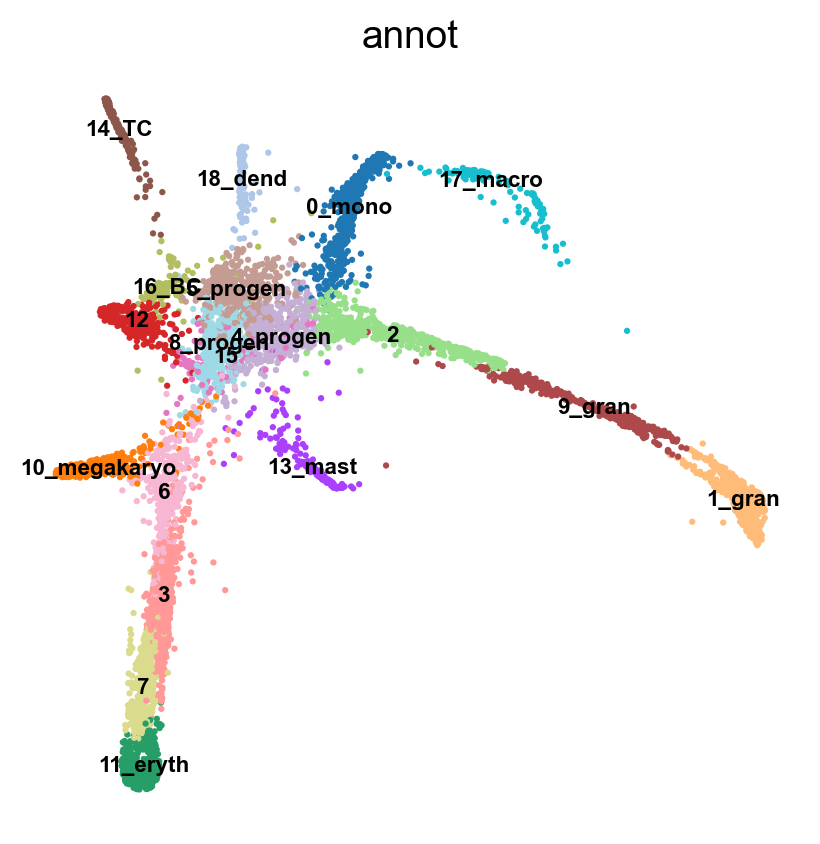

In [17]:
# use the umap to initialize the graph layout.
sc.tl.draw_graph(adata, init_pos='X_umap')
sc.pl.draw_graph(adata, color='annot', legend_loc='on data', legend_fontsize = 'xx-small')

In [18]:
sc.tl.paga(adata, groups='annot')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


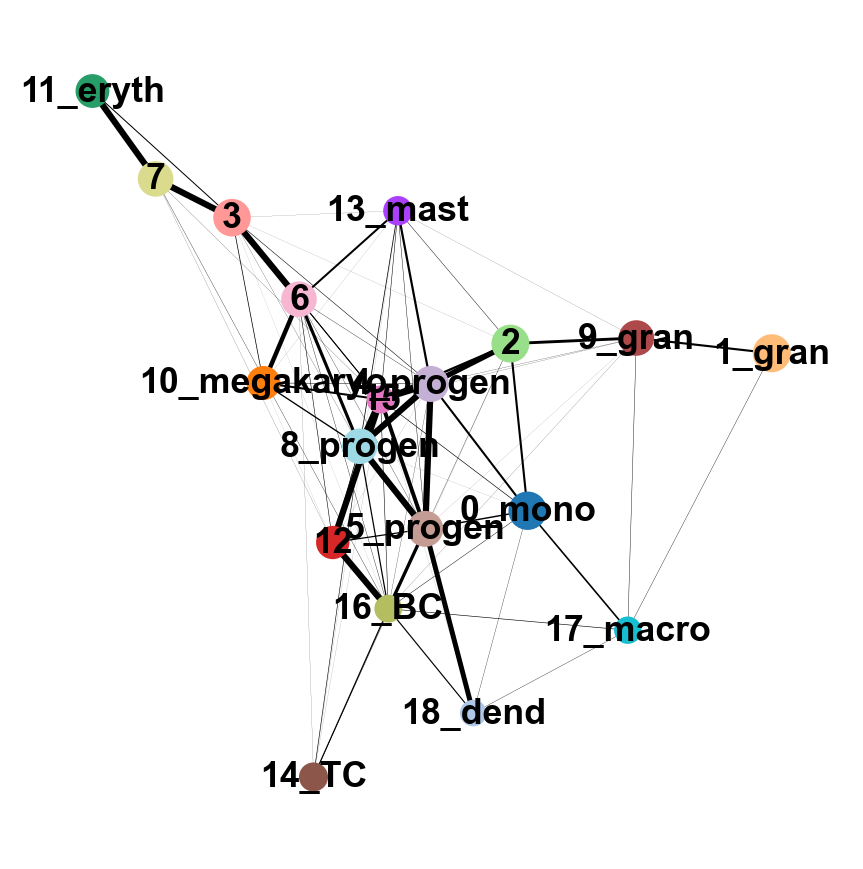

In [19]:
sc.pl.paga(adata, color='annot', edge_width_scale = 0.3)

As you can see, we have edges between many clusters that we know are are unrelated, so we may need to clean up the data a bit more.

## Data pre-processing prior trajectory inference

First, lets explore the graph  a bit.  So we plot the umap with the graph connections on top.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


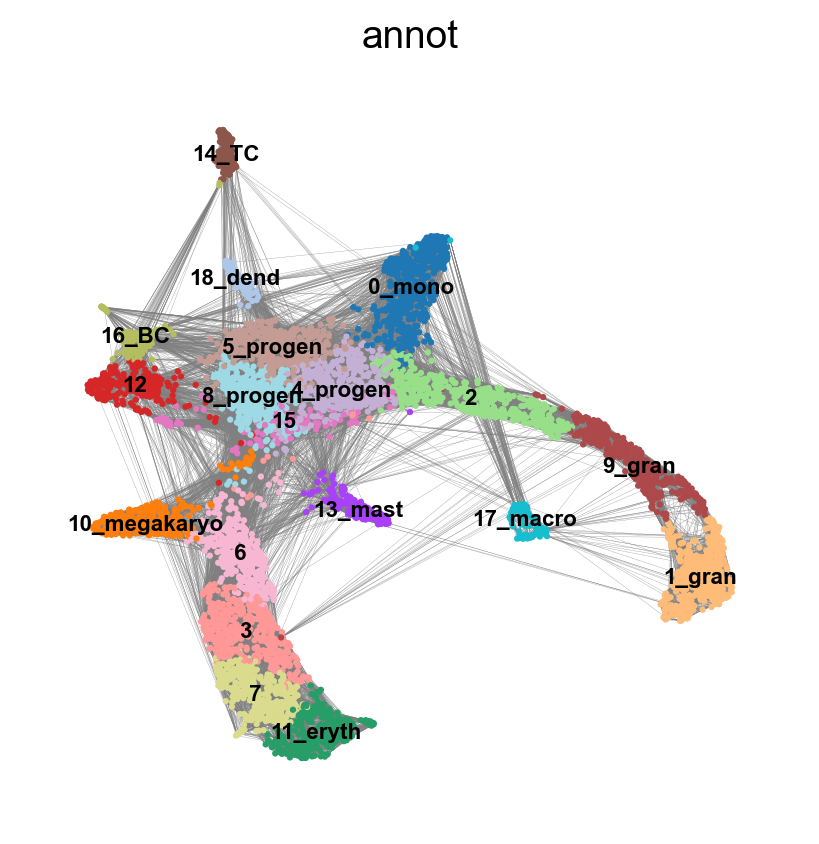

In [20]:
sc.pl.umap(adata, edges=True, color = 'annot', legend_loc= 'on data', legend_fontsize= 'xx-small')

We have many edges in the graph between unrelated clusters, so lets try with fewer neighbors.

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


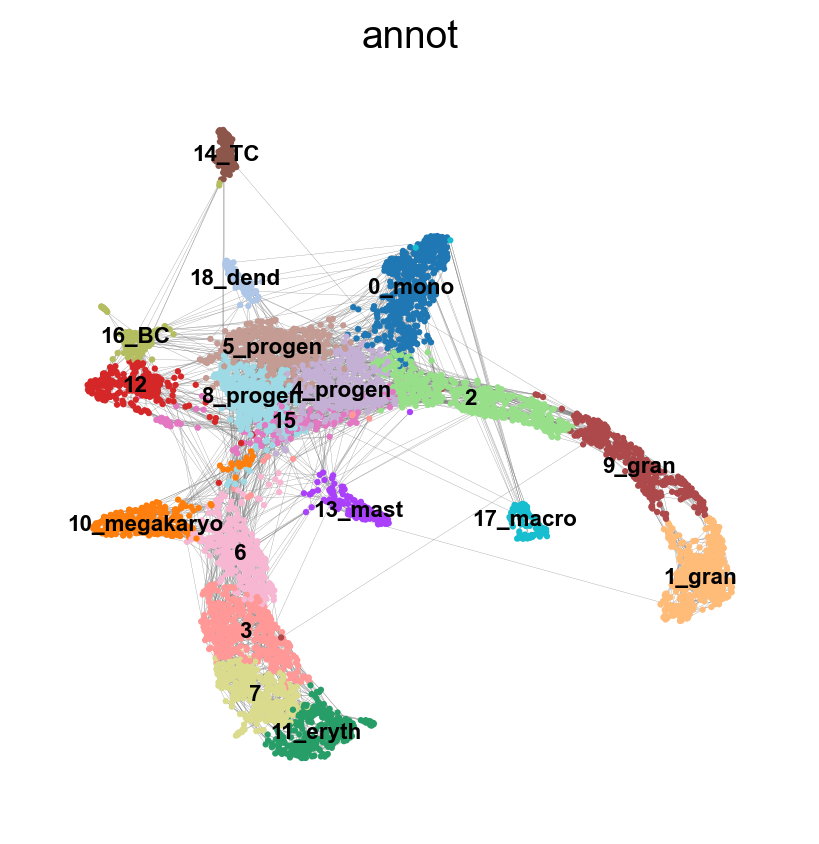

In [21]:
sc.pp.neighbors(adata, n_neighbors=5,  use_rep = 'X_harmony_Phase', n_pcs = 30)

sc.pl.umap(adata, edges=True, color = 'annot', legend_loc= 'on data', legend_fontsize= 'xx-small')

Rerun PAGA again on the data



drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:26)


/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


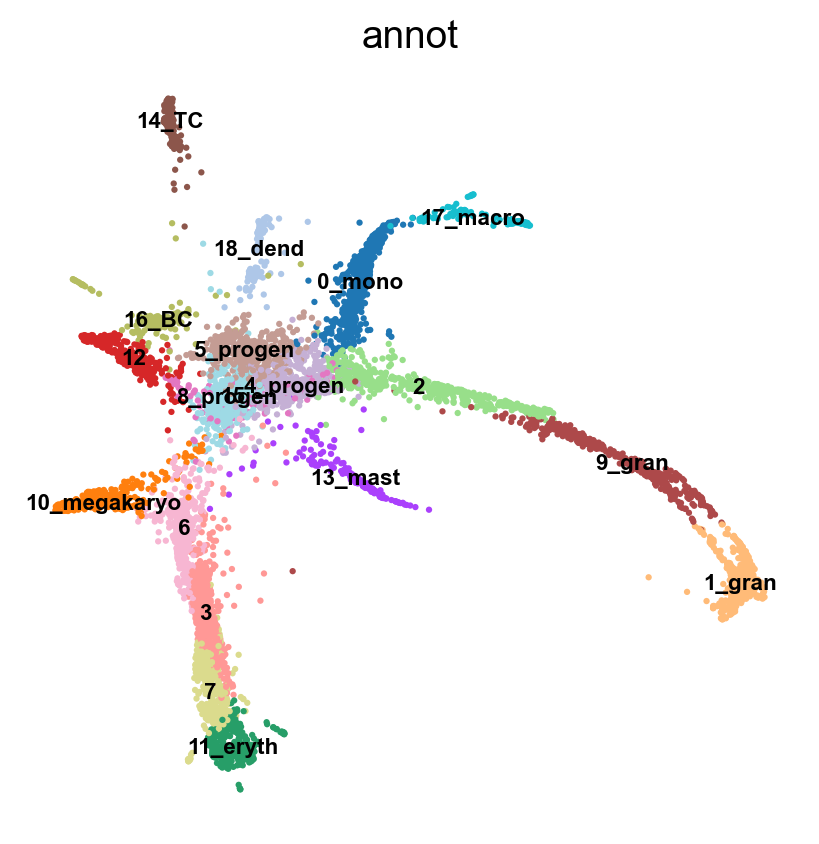

In [22]:
sc.tl.draw_graph(adata, init_pos='X_umap')
sc.pl.draw_graph(adata, color='annot', legend_loc='on data', legend_fontsize = 'xx-small')


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


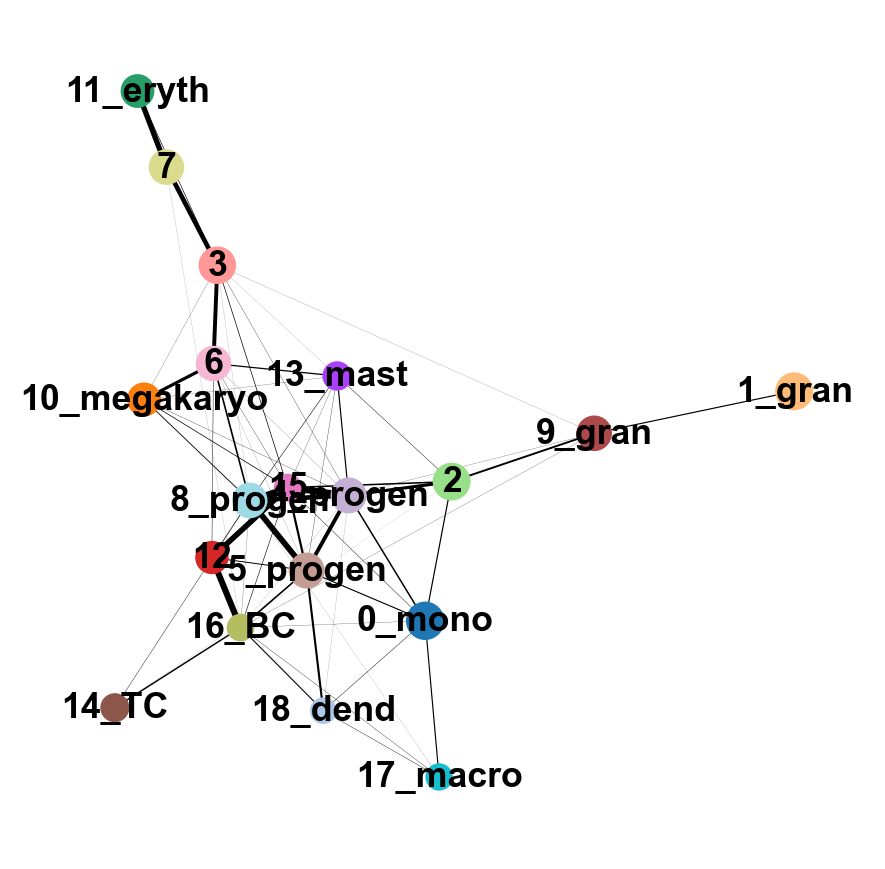

In [23]:
sc.tl.paga(adata, groups='annot')
sc.pl.paga(adata, color='annot', edge_width_scale = 0.3)

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [24]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:26)


Now we can see all marker genes also at single-cell resolution in a meaningful layout.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


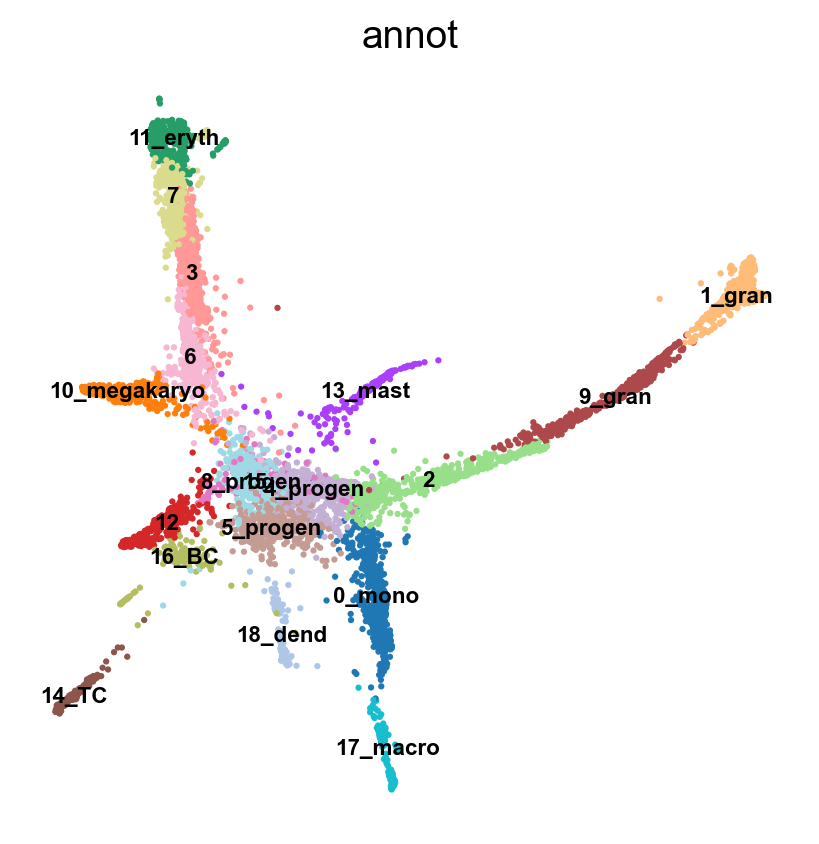

In [25]:
sc.pl.draw_graph(adata, color=['annot'], legend_loc='on data', legend_fontsize=  'xx-small')

Compare the 2 graphs

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


--> added 'pos', the PAGA positions (adata.uns['paga'])


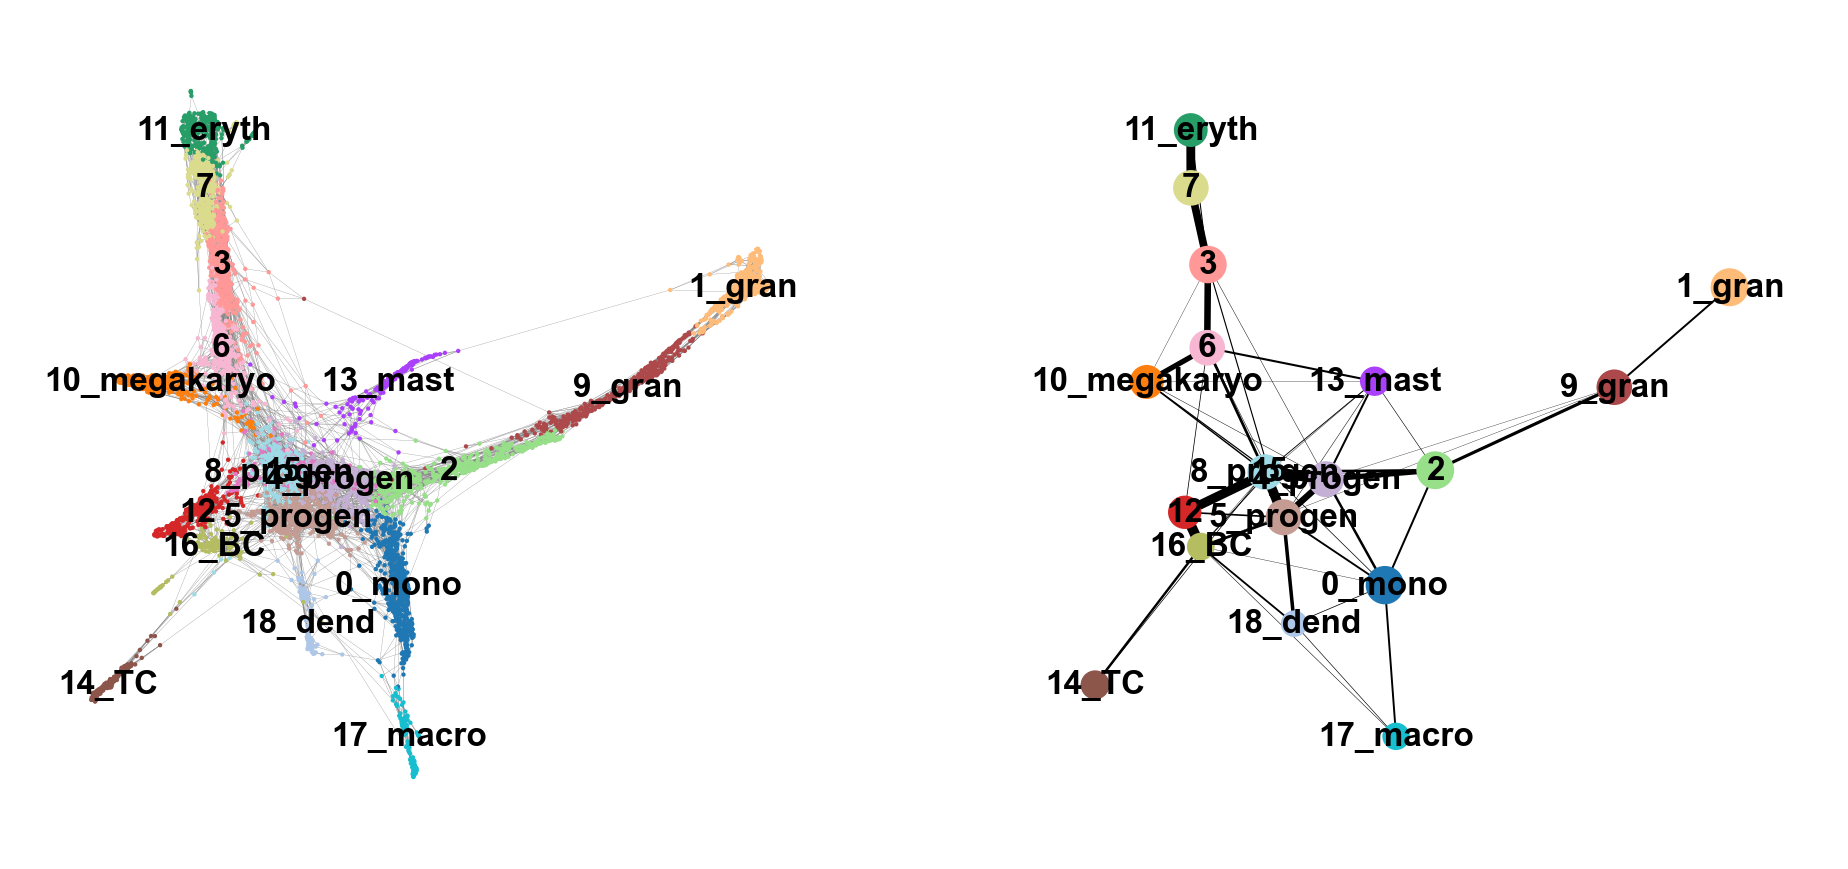

In [26]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime. We have 3 progenitor clusters, but cluster 5 seems the most clear.

In [27]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['annot']  == '5_progen')[0]

In [28]:
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9989591  0.997628   0.9970365  0.9956704  0.99334306
     0.9918951  0.9915921  0.99013233 0.98801893 0.9870309  0.9861044
     0.9851118  0.9845008  0.9839531 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Use the full raw data for visualization.

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


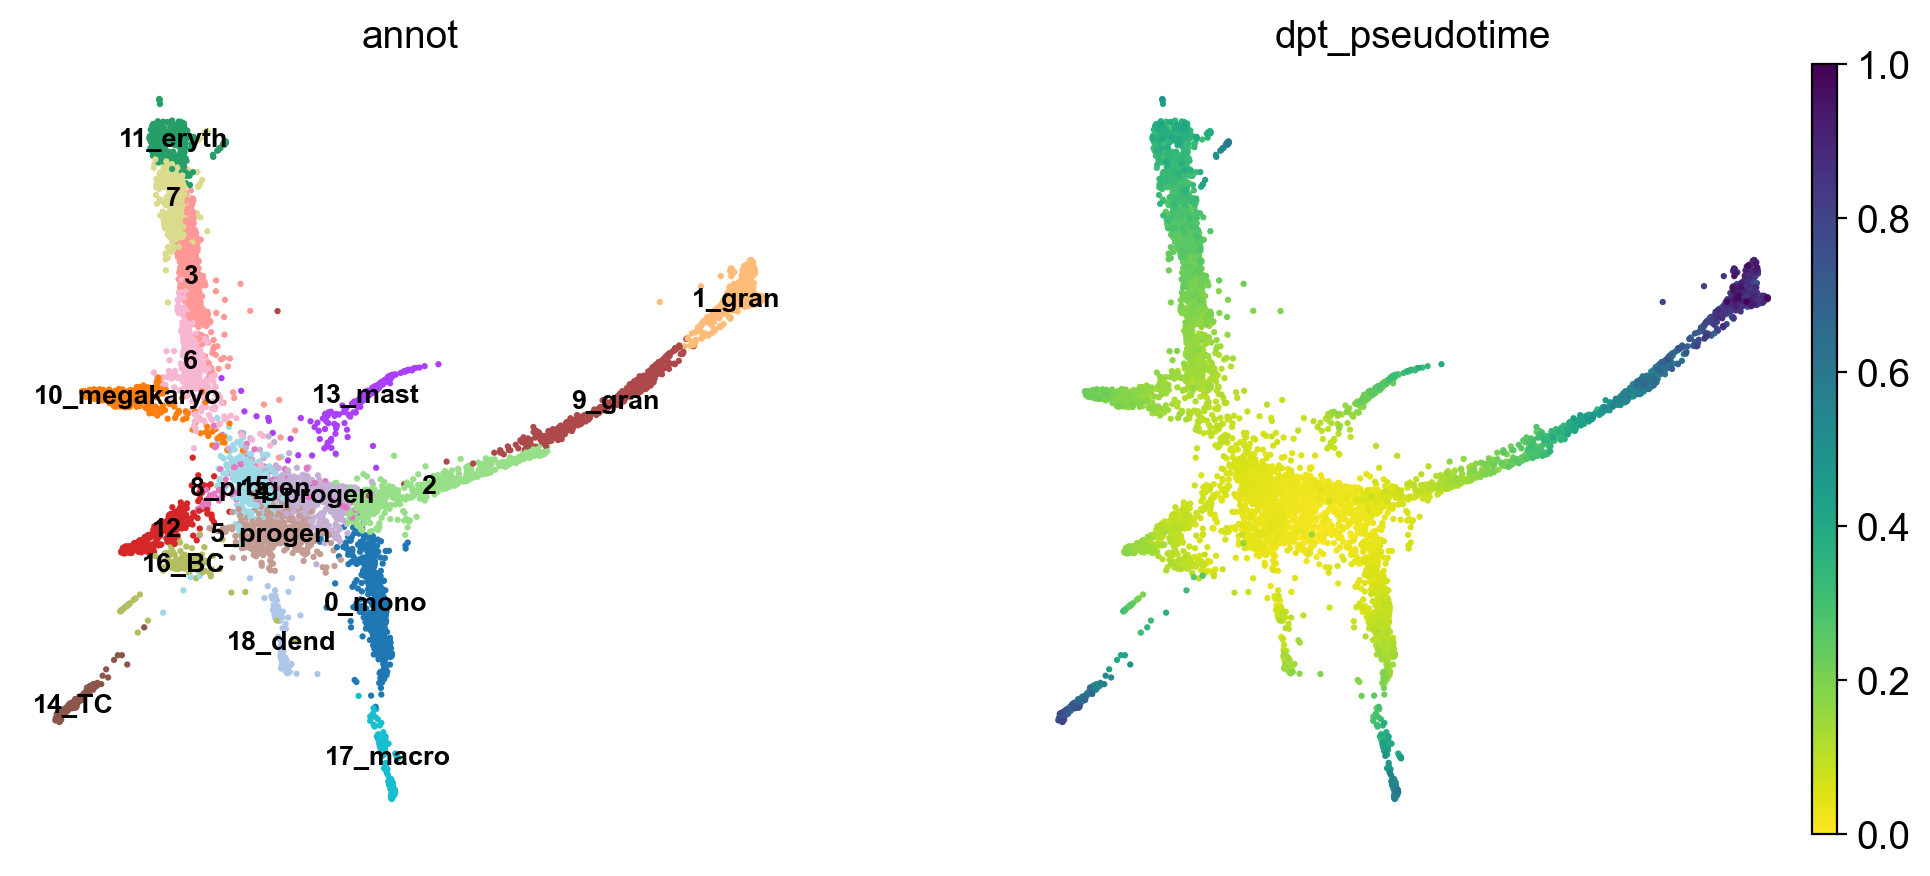

In [29]:
sc.pl.draw_graph(adata, color=['annot', 'dpt_pseudotime'], legend_loc='on data', legend_fontsize= 'x-small')

By looking at the different know lineages and the layout of the graph we define manually some paths to the graph that corresponds to spcific lineages.

In [30]:
# Define paths

paths = [('erythrocytes', ['5_progen', '8_progen', '6','3','7', '11_eryth']),
         ('lympoid', ['5_progen', '12', '16_BC', '14_TC']), 
         ('granulo', ['5_progen', '4_progen', '2', '9_gran', '1_gran']),
         ('mono', ['5_progen','4_progen','0_mono','18_dend','17_macro'])
        ]

In [31]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [32]:
!mkdir write

mkdir: write: File exists


Then we select some genes that can vary in the lineages and plot onto the paths.

In [33]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg',                     # monocyte
              'Itga2b','Prss34','Cma1','Procr',            # Megakaryo,Basophil,Mast,HPC
             'C1qc','Siglech','Ms4a1','Cd3e','Cd34']

/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/asabjor/miniconda3/envs/scRNAseq2023_python/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


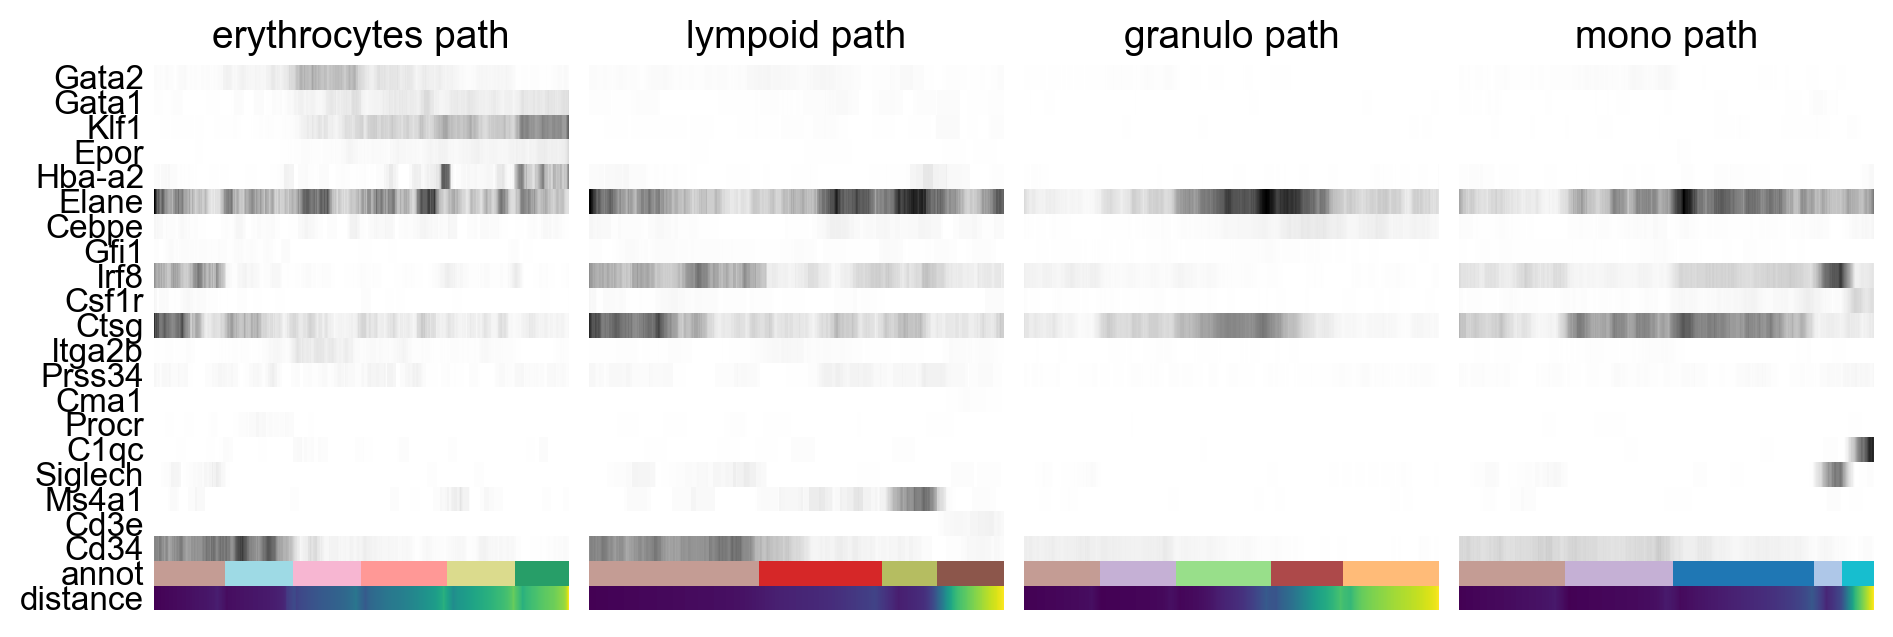

In [34]:
_, axs = pl.subplots(ncols=4, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='annot',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        use_raw = False,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path.pdf')
pl.show()

## Your turn

As you can see, we can manipulate the trajectory quite a bit by selecting different number of neighbors, components etc. to fit with our assumptions on the development of these celltypes. 

Please explore furhter how you can tweak the trajectory. For instance, can you create a PAGA trajectory using the orignial umap from Seurat instead?  Hint, you first need to compute the neighbors on the umap 